# 🔍 Log-Transformed XGBoost – Final Model Tuning for Airbnb Price Prediction

In this notebook, I tuned  the Airbnb price prediction model one step further by applying a **log transformation** on the `price` variable to address skewness in data points & stabilize variance. This, combined with **advanced hyperparameter tuning** utilizing `RandomizedSearchCV`, to significantly improve model performance over previous attempt.

Goal here is to:
- ✅ Reduce the influence of extreme price outliers data point
- ✅ Improve prediction accuracy and XGB model stability
- ✅ Achieve **lower RMSE** and **higher R²** than all previous models to explain changes. 

This notebook builds upon the work done in:
📁 [`03_model_xgboost.ipynb`](03_model_xgboost.ipynb)

---

## 💡 Why opted for Log Transform?

Airbnb prices typically follow a right-skewed distribution due to luxury listings. By applying a log transform, we:
- Normalize the target (`price`) variable
- Improve the XGB model’s ability to underlying learn patterns
- Reduce the impact of (right-skewed) outliers on training dataset. 

---

## 📊 Summary of Results (After Transformation + Hyperparameter Tuning)

| Metric | Value |
|--------|--------|
| **RMSE** | `$54.38` |
| **MAE** | `$30.95` |
| **R²** | `0.6711` ~ 68% ✅

---

## 📎 Outcome

This is my **best-performing model** in the entire project, suitable for real-world Airbnb price estimation. Generated few Visualizations and feature importance charts further validate the model’s predictive power and interpretability for general audience.


In [70]:
#import required library dependency 
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
#load data
ce_data = pd.read_csv('../outputs/airbnb_cleaned_encoded.csv')

# Log transform target
ce_data['log_price'] = np.log1p(ce_data['price'])

#Log transformed target 'price' variable along with accommodate , bedrooms, bathrooms, number_of_reviews
for col in ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']:
    ce_data[col] = np.log1p(ce_data[col])

# Drop original price & log price from features
X = ce_data.drop(['log_price', 'price'], axis=1)
y = ce_data['log_price']

#TrainTestSplit Training & Testing purpose setting test_size = 0.2 & randomstate = 42
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [72]:
#Double check Price and log_Price target variable not present 
# Issue if data leaks like previous run 
print(X.columns)


Index(['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights',
       'number_of_reviews', 'review_scores_rating', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Bed & Breakfast',
       ...
       'neighbourhood_cleansed_Wedgwood',
       'neighbourhood_cleansed_West Queen Anne',
       'neighbourhood_cleansed_West Woodland',
       'neighbourhood_cleansed_Westlake',
       'neighbourhood_cleansed_Whittier Heights',
       'neighbourhood_cleansed_Windermere',
       'neighbourhood_cleansed_Yesler Terrace', 'instant_bookable_t',
       'cancellation_policy_moderate', 'cancellation_policy_strict'],
      dtype='object', length=113)


In [73]:
parameter_grid = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 3, 5],
    'min_child_weight': [1, 3, 5]
}



In [74]:
#XGB Model tuning & definition
xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=parameter_grid,
    n_iter=52,  # using higher number for n depth search 
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#fitted train values
random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

#results
print("✅ Best Parameters:", random_search.best_params_)
print("📊 Best CV R² Score:", random_search.best_score_)

Fitting 5 folds for each of 52 candidates, totalling 260 fits
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=800, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=3, learning_rate=0.01, ma

In [75]:
#Generate predicted price for comparision
y_pred_price = np.expm1(y_pred_best)
y_test_actual = np.expm1(y_test)

# Eval. accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#RMSE MAE R2 values
rmse = mean_squared_error(y_test_actual, y_pred_price, squared=False)
mae = mean_absolute_error(y_test_actual, y_pred_price)
r2 = r2_score(y_test_actual, y_pred_price)

print("📈 Log-Transformed Model Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

📈 Log-Transformed Model Results:
RMSE: 54.38
MAE: 30.95
R²: 0.6711


In [76]:
#Stored pred. values in dataframe 
pred_df = pd.DataFrame({
    'Actual Price': y_test_actual,
    'Predicted Price': y_pred_price,
    'Error': y_test_actual - y_pred_best
})

##print(pred_df)


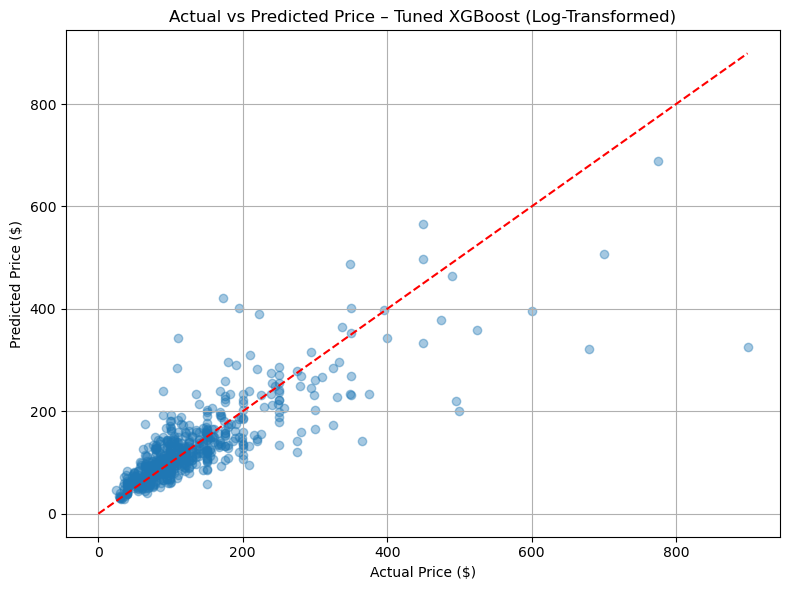

<Figure size 640x480 with 0 Axes>

In [77]:
#Result Plot:1 Actual vs Predicted Price export to images folder later
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_best), alpha=0.4)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Price – Tuned XGBoost (Log-Transformed)")
plt.grid(True)
plt.tight_layout()
plt.show()

#save image
plt.savefig('../images/Actual vs Predicted Price – Tuned XGBoost (Log-Transformed).png')


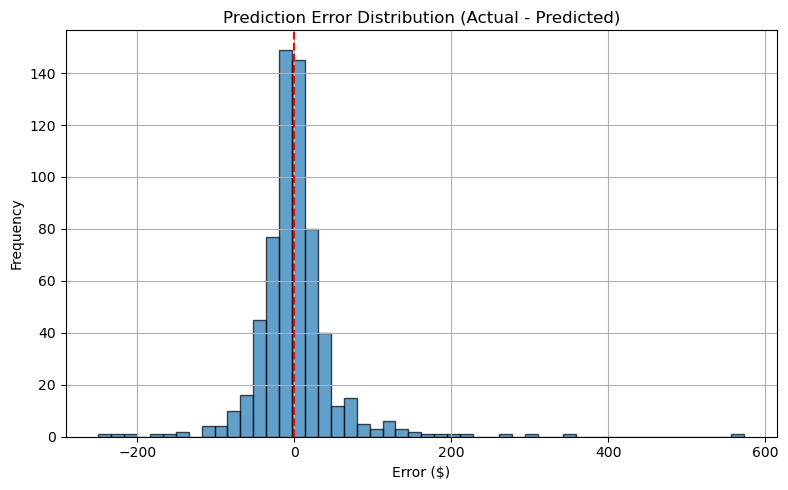

<Figure size 640x480 with 0 Axes>

In [80]:
#Result Plot 2: Prediction Error Distribution 
errors = np.expm1(y_test) - np.expm1(y_pred_best)

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction Error Distribution (Actual - Predicted)")
plt.xlabel("Error ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig('../images/Prediction Error Distribution (Actual - Predicted).png')


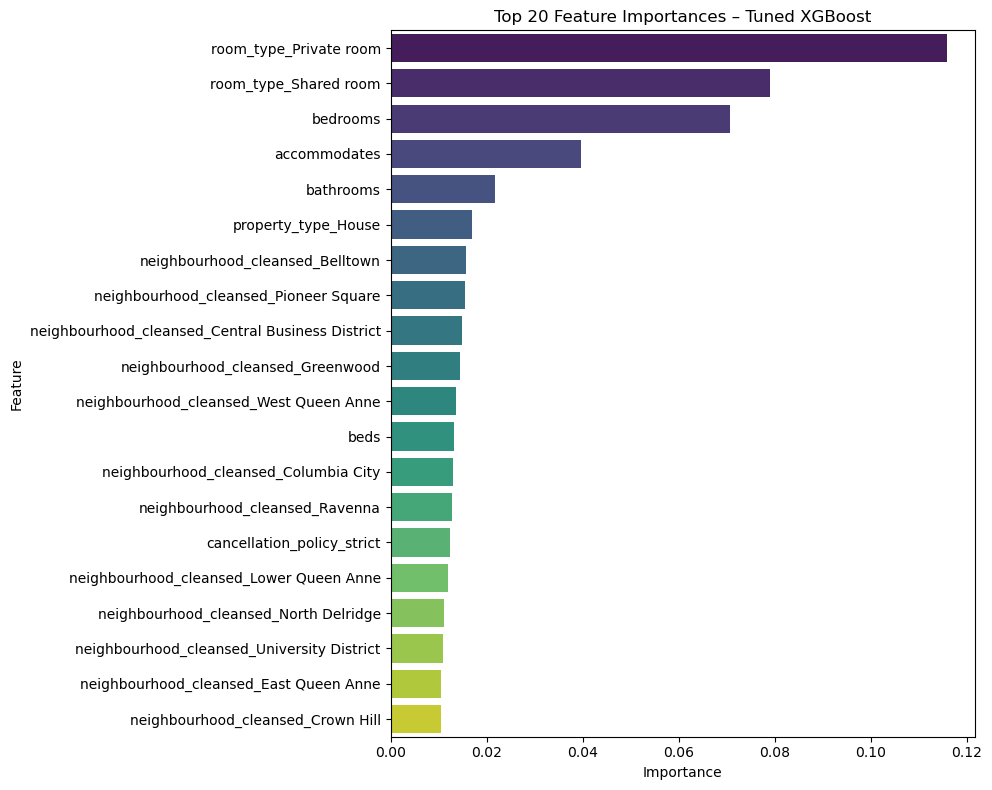

<Figure size 640x480 with 0 Axes>

In [79]:
#Result Plot:3 Important Features  
importances = best_xgb.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances – Tuned XGBoost')
plt.tight_layout()
plt.show()

#save image 
plt.savefig('../images/Top 20 Feature Importances – Tuned XGBoost.png')


In [ ]:
## Findings
# room_type_Private room, Shared room, bedrooms, and accommodates are the strongest predictors.
# Certain neighborhoods like Belltown, Pioneer Square, and Greenwood also contribute meaningfully.